In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#% matplotlib inline
from datetime import datetime

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import iplot

from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
nltk.download('maxent_ne_chunker')
nltk.download('words')

import string
import gensim
import collections
from gensim.corpora import Dictionary

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from autocorrect import Speller

from bs4 import BeautifulSoup
import requests
import csv
import time

import re
import string
import gc
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package words is already up-to-date!


#### Using the arXiv API

In [2]:
import requests 
import datetime as dt
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [3]:
# Parameters
query = '(misogyny OR sexism OR sexist OR gender OR "online hate" OR "online abuse") AND ("social media" OR "social platform" OR twitter OR Twitter OR Facebook OR facebook OR reddit OR Reddit OR instagram OR Instagram OR meta OR linkedin OR LinkedIn OR youtube OR YouTube)' 

# original query only gave 22 results. This gives 405 results
max_results = 1000

In [4]:
#Call arXiv API with the query parameters
url = f'http://export.arxiv.org/api/query?search_query={query}&max_results={max_results}'
resp = requests.get(url)

In [5]:
# Parse the response.
# The response is in XML format. We’ll use an XML parser to parse the response
ns = { 'r':'http://www.w3.org/2005/Atom'}
root = ET.fromstring(resp.text)

# Construct the dataframe from the response
all_papers = list()
entries = root.findall('r:entry',namespaces=ns)
for entry in entries :
    all_papers.append({l.tag[l.tag.index('}')+1:] :l.text for l in entry})

all_papers_df=pd.DataFrame(all_papers)
all_papers_df.columns

Index(['id', 'updated', 'published', 'title', 'summary', 'author', 'comment',
       'link', 'primary_category', 'category', 'doi', 'journal_ref'],
      dtype='object')

In [6]:
len(all_papers_df) # Seems to give different lengths everytime

406

In [7]:
all_papers_df['primary_category'].isna().sum(), all_papers_df['category'].isna().sum() 

(406, 406)

In [8]:
all_papers_df['journal_ref'].isna().sum(), all_papers_df['doi'].isna().sum()

(359, 336)

In [9]:
# Joining the titles and the abstracts 
all_papers_df['title & abstract'] = all_papers_df['title'] + ' ' + all_papers_df['summary']

# Converting to datetime format
all_papers_df['year'] = pd.to_datetime(all_papers_df['published']).dt.year

In [10]:
# Removing dates till 2012 in post-filtering as only 'updated' and 'published' parameters are there
all_papers_df = all_papers_df[all_papers_df.year > 2012]

In [11]:
import datetime
%time
def initial_process(df):
    data = df.copy()
    data = data[~data['summary'].isnull()]  # Remove rows with empty content

    # Select contents of length between 140 and 2000 characters.
    data = data[(data.summary.map(len) > 140) & (data.summary.map(len) <= 2000)]
    data.reset_index(inplace=True, drop=True)

    # collecting 10000 random sample for computational ease
    #data = data.sample(10000, random_state=2021)
    #data.reset_index(inplace=True, drop=True)
    

    # aligning the columns in order of requirement
    data = data[['year', 'title', 'summary']]
    # renaming date -> date_of_news
    #data.rename(columns = {'date': 'date_of_news'}, inplace = True)
    return (data)

data = initial_process(all_papers_df)
data.tail(3)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


,year,title,summary
397,2022,Adaptive Fairness-Aware Online Meta-Learning f...,The fairness-aware online learning framework...
398,2016,Surveying Turkish high school and university s...,Student attitudes and approaches to problem ...
399,2020,Large image datasets: A pyrrhic win for comput...,In this paper we investigate problematic pra...


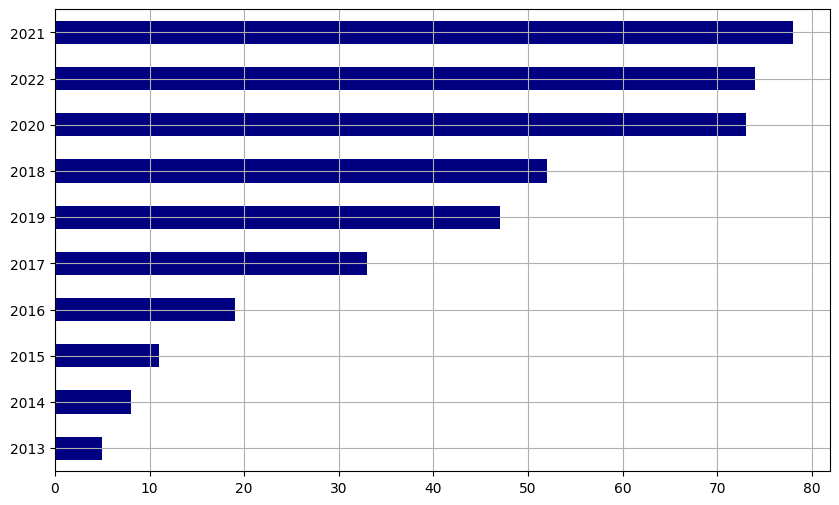

In [12]:
years = data['year'].value_counts().to_frame()[:30]
years.sort_values(by='year', ascending=True).plot(
    kind = 'barh', colormap='jet', legend=False, figsize=(10, 6));
plt.grid(True)

In [13]:
df_pub_years = pd.DataFrame({
    'year': data['year'].dropna().unique(),
    'count': data['year'].value_counts().tolist()
})
df_pub_years = df_pub_years.sort_values(by='year', ascending=True)
tick_val = df_pub_years.year.to_list()

fig = px.bar(df_pub_years, x="year", y="count", color= "count", 
            hover_data=['year'], text ='count')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Number of preprints by years', title_x=0.5, title_y=0.92,
    showlegend=False)
fig.update_yaxes(range=[0,90])
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = tick_val,
        ticktext = tick_val
    )
)
fig.update_coloraxes(showscale=False)

fig.show()

### Further preprocessing

In [14]:
%time
def preProcess(text):
    #  Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()                   # lower case lowers the sparsity of the data
  
    # remove numbers
    text = re.sub(r'\d+', '', str(text))

    # removing salutaions (if any)
    text = re.sub("Mr\.",'Mr',  str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))

    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r'won\'t', 'will not', text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r'(\w+)\'s', '\g<1> is', text)
    text = re.sub(r'(\w+)\'ve', '\g<1> have', text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

   
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
  
    # removing any reference to outside text
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)

    text = text.strip()
    return text

# preprocessing texts
data['processedsummary'] = data['summary'].apply(preProcess)
data.head(3)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,in this paper we present a benchmark dataset g...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn has become of gre...


##### Removing rare words

In [15]:
%time
num_of_rare_words = 25
RARE_WORDS = set([w for (w, wc) in collections.Counter().most_common()[:-num_of_rare_words-1:-1]])
def remove_rare_words(text):
    return " ".join([word for word in str(text).split() if word not in RARE_WORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_rare_words(text))
data.head(3)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,in this paper we present a benchmark dataset g...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn has become of gre...


##### Frequent words removal

In [16]:
%time
FREQ_WORDS = set([w for (w, wc) in collections.Counter().most_common(25)])
def remove_freq_words(text):
    return " ".join([word for word in str(text).split() if word not in FREQ_WORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_freq_words(text))
data.head(3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,this paper investigates when users create prof...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,in this paper we present a benchmark dataset g...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn has become of gre...


##### Stopwords removal

In [17]:
%time

stop_words = set(stopwords.words('english'))

# add words that aren't in the NLTK stopwords list
STOPWORDS = list(stop_words)
#print(STOPWORDS); print()
#print(len(STOPWORDS))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_stopwords(text))
data.head(5)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates users create profiles diffe...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,paper present benchmark dataset generated part...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn become great infl...
3,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
4,2018,#ILookLikeAnEngineer: Using Social Media Based...,"Each year, significant investment of time an...",year significant investment time resources mad...


##### Lemmatizing

In [18]:
wnl = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([wnl.lemmatize(word) for word in text.split()])

data["processedsummary"] = data["processedsummary"].apply(lambda text: lemmatize_words(text))
data.head()

,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates user create profile differe...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,paper present benchmark dataset generated part...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn become great infl...
3,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
4,2018,#ILookLikeAnEngineer: Using Social Media Based...,"Each year, significant investment of time an...",year significant investment time resource made...


##### Remove punctuations

In [19]:
%time
PUNCT_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_REMOVE))

data["processedsummary"] = data["processedsummary"].apply(lambda text: remove_punctuation(text))
data.head()


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs


,year,title,summary,processedsummary
0,2017,Wearing Many (Social) Hats: How Different are ...,This paper investigates when users create pr...,paper investigates user create profile differe...
1,2021,Benchmark dataset of memes with text transcrip...,In this paper we present a benchmark dataset...,paper present benchmark dataset generated part...
2,2015,Ang Social Network sa Facebook ng mga Taga-Bat...,Online social networking (OSN) has become of...,online social networking osn become great infl...
3,2021,Let-Mi: An Arabic Levantine Twitter Dataset fo...,Online misogyny has become an increasing wor...,online misogyny become increasing worry arab w...
4,2018,#ILookLikeAnEngineer: Using Social Media Based...,"Each year, significant investment of time an...",year significant investment time resource made...


##### Tokenization

In [20]:
# tokenizer to 'processedContent' column through all rows and store in 'tokens' column.
data['tokens'] = data['processedsummary'].apply(word_tokenize) 

#  POS tagging of the sentence and ne_chunk() to recognize each named entity in sentences
data['ner'] = data['processedsummary']\
    .apply(lambda x: nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x)),binary=True))
data.tail(3)

,year,title,summary,processedsummary,tokens,ner
397,2022,Adaptive Fairness-Aware Online Meta-Learning f...,The fairness-aware online learning framework...,fairness aware online learning framework arise...,"[fairness, aware, online, learning, framework,...","[(fairness, NN), (aware, JJ), (online, JJ), (l..."
398,2016,Surveying Turkish high school and university s...,Student attitudes and approaches to problem ...,student attitude approach problem solving impa...,"[student, attitude, approach, problem, solving...","[(student, NN), (attitude, NN), (approach, NN)..."
399,2020,Large image datasets: A pyrrhic win for comput...,In this paper we investigate problematic pra...,paper investigate problematic practice consequ...,"[paper, investigate, problematic, practice, co...","[(paper, NN), (investigate, NN), (problematic,..."


### Term Document Frequency

In [21]:
%time
yDf = data[['year', 'title', 'tokens']].copy()

bigram = gensim.models.Phrases(yDf['tokens'], min_count=5, threshold=100)
bigramModel = gensim.models.phrases.Phraser(bigram)

yDf['bigramTokens'] = yDf['tokens'].progress_map(lambda tokens: bigramModel[tokens])

# Creating Dictionary
id2word = Dictionary(yDf['bigramTokens'])

# Creating Corpus
texts = yDf['bigramTokens'].tolist()
dictionary = Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.86 µs


progress-bar: 100%|██████████| 400/400 [00:00<00:00, 16479.92it/s]


### Defining LDA model

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


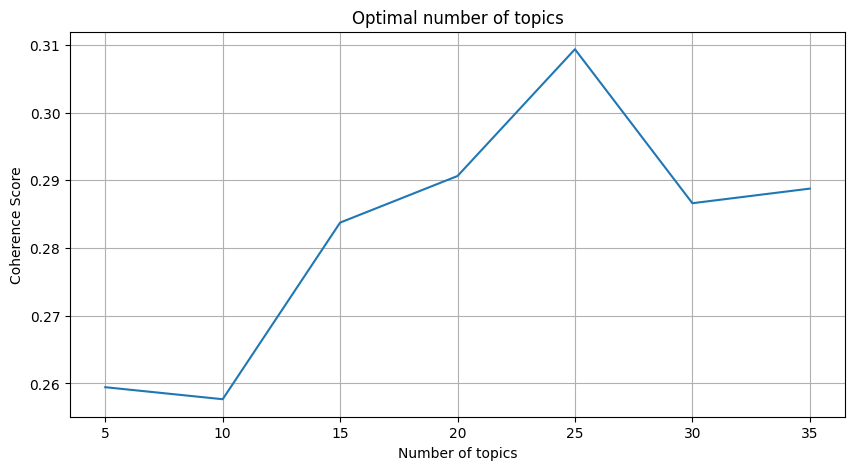

In [22]:

%time

# Define LDA model in function that takes the number of topics as a parameter.
def LDAmodel(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(
        corpus=tqdm(corpus, leave=False),
        id2word=id2word,
        alpha='auto', eta='auto',
        num_topics=num_topics, # the number of topics is equal to num_topics
        random_state=2021,
        eval_every=1,
        chunksize=2000,
        passes=passes,
        per_word_topics=True
        )
    
def coherence_computation(model):
    coherence = CoherenceModel(
        model = model, 
        texts = texts,
        dictionary = id2word, coherence='c_v'
        )
    return coherence.get_coherence()

def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    DATA = pd.DataFrame(topics)
    DATA.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    DATA.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return DATA

def explore_models(DATA, range = range(5, 25)):
    id2word = Dictionary(DATA['bigramTokens'])
    texts = DATA['bigramTokens'].tolist()
    corpus = [id2word.doc2bow(text) for text in texts]

    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(range, leave=False):
        lda = LDAmodel(num_topics, passes=5)
        model_list.append(lda)
        coherence = coherence_computation(lda)
        coherence_values.append(coherence)
      
    fig = plt.figure(figsize=(10,5))
    plt.title('Optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.plot(range, coherence_values)
    
    return coherence_values, model_list

coherence_values, model_list = explore_models(yDf, range = range(5, 40, 5))

##### Printing the coherence scores

In [23]:
# Print the coherence scores
limit=40; start=5; step=6;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2594
Num Topics = 11  has Coherence Value of 0.2577
Num Topics = 17  has Coherence Value of 0.2837
Num Topics = 23  has Coherence Value of 0.2906
Num Topics = 29  has Coherence Value of 0.3093
Num Topics = 35  has Coherence Value of 0.2866


In [24]:
pd.options.display.max_columns = 20
bestModel = LDAmodel(num_topics=10, passes=5)
print(display_topics(model = bestModel))

         keyword_1    keyword_2    keyword_3    keyword_4    keyword_5  \
topic_0     social       gender         bias  demographic        study   
topic_1  political       gender        study         word     language   
topic_2     gender         data     analysis        model       social   
topic_3     gender       social       medium         user       online   
topic_4     gender         user       social        model        using   
topic_5     social  hate_speech        study       medium       gender   
topic_6       user       social  hate_speech       online    community   
topic_7     gender         bias         user        study      student   
topic_8      model         user       social         data         task   
topic_9     gender         bias       social         user  demographic   

        keyword_6  keyword_7    keyword_8    keyword_9 keyword_10  
topic_0      user    network         data       online      model  
topic_1     model       data       social        

In [25]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=bestModel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nc_v Coherence Score: ', coherence_lda)


c_v Coherence Score:  0.25766863057033557


In [26]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=bestModel, texts=texts, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nUMass Coherence Score: ', coherence_lda)


UMass Coherence Score:  -1.6101767575008339


### Topic modelling

In [27]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sentence_transformers import SentenceTransformer
import hdbscan
import matplotlib.pyplot as plt

import umap

#### Sentence embeddings

In [28]:
#https://www.kdnuggets.com/2020/11/topic-modeling-bert.html
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

data1 = data['processedsummary']

#train_df.loc[pd.isnull(train_df.selected_text),:]

embeddings = model.encode(data1, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [29]:
data1.iloc[10]

'understanding human behavior important task application many domain targeted advertisement health analytics security entertainment etc purpose designing system activity recognition ar important however since every human different behavior understanding analyzing common pattern become challenging task since smartphones easily available every human modern world using track human activity becomes possible paper extracted different human activity using accelerometer magnetometer gyroscope sensor android smartphones building android mobile application using different social medium application facebook instagram whatsapp twitter extracted raw sensor value along attribute subject along attribute class label age gender left right hand application usage extract feature raw signal use perform classification using different machine learning ml algorithm using statistical analysis show importance different feature towards prediction class label end use trained ml model data extract unknown featur

In [30]:
len(data1)

400

In [31]:
embeddings.shape

(400, 768)

UMAP has several hyperparameters that can have a significant impact on the resulting embedding. The four major ones are listed below:

```n_neighbors``` - This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data.

```min_dist``` - This parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation.

```n_components``` - This allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into. 

```metric``` - This controls how distance is computed in the ambient space of the input data. 

Each of these parameters has a distinct effect, and we will look at each in turn. To make exploration simpler we will first write a short utility function that can fit the data with UMAP given a set of parameter choices, and plot the result.

In [54]:
umap_data_1 = umap.UMAP(n_neighbors=200, n_components=50, min_dist=0.5, metric='cosine').fit_transform(embeddings)
umap_data_1.shape

(400, 50)

The primary parameter to effect the resulting clustering is min_cluster_size. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster. 

In [55]:
umap_data_2 = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.2, metric='cosine').fit_transform(umap_data_1)
umap_data_2.shape

(400, 2)

In [56]:
# Prepare data

cluster = hdbscan.HDBSCAN(min_cluster_size=8,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_data_2)

result = pd.DataFrame(umap_data_2, columns=['x', 'y'])
result['labels'] = cluster.labels_

len(result.labels.unique())

12

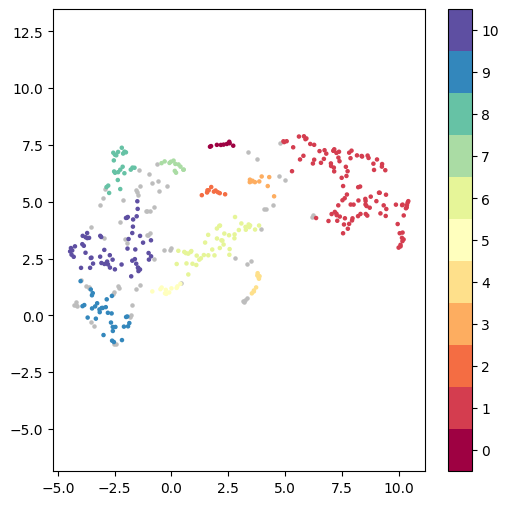

In [57]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(6, 6))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11)) 

In [58]:
len(result[result.labels==-1])

71

In [59]:
result[result.labels==3]

,x,y,labels
100,3.676529,5.862548,3
109,3.570883,5.922145,3
111,3.449418,5.861622,3
114,4.305013,6.084981,3
128,3.455547,5.972013,3
187,3.867517,5.893186,3
213,3.540831,5.897481,3
258,3.972560,6.111007,3
368,4.239607,5.689989,3
369,4.519788,5.238523,3


#### Applying class-based TF-IDF

In [60]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [61]:
docs_df = pd.DataFrame(data)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
#docs_per_topic = docs_df.groupby(['Topic'], as_index = False)
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'processedsummary': ' '.join})

In [62]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic['processedsummary'].values, m=len(data))

##### Topic representation

In [63]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     ['processedsummary']
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "processedsummary": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
2,1,110
0,-1,71
11,10,58
7,6,44
10,9,33
9,8,23
8,7,12
6,5,11
3,2,10
4,3,10


In [64]:
top_n_words[2][:30]

[('follower', 0.0783171982989248),
 ('clinton', 0.057329082967057646),
 ('trump', 0.054934860357882934),
 ('candidate', 0.05397715808205389),
 ('hillary', 0.04027822914211733),
 ('presidential', 0.03323314823526069),
 ('sander', 0.03243015504154384),
 ('donald', 0.031239802301565013),
 ('leave', 0.02702512920128653),
 ('follow', 0.026549028012473507),
 ('woman', 0.02648064810917012),
 ('likely', 0.025833178742251967),
 ('influencers', 0.023707439824906522),
 ('following', 0.02081565776914018),
 ('card', 0.020139114571058665),
 ('number', 0.019362581034076405),
 ('champion', 0.01889132146115781),
 ('camp', 0.01889132146115781),
 ('clintonists', 0.01889132146115781),
 ('september', 0.017780579868679893)]

In [65]:
top_n_words[1][:30] 

[('hateful', 0.011166118450782045),
 ('abusive', 0.008746436009803576),
 ('detection', 0.008642291856073677),
 ('speech', 0.008383076179960154),
 ('content', 0.007274357172846652),
 ('offensive', 0.007196991304735102),
 ('score', 0.006462691680826745),
 ('hate', 0.006285530104282081),
 ('tweet', 0.006108186955882705),
 ('covid', 0.006096741072514101),
 ('anti', 0.005901152458773753),
 ('counter', 0.0053653370824255295),
 ('racism', 0.005256476940550962),
 ('datasets', 0.005255737437783504),
 ('asian', 0.005183899386737794),
 ('comment', 0.005137996397051281),
 ('detect', 0.0050762180520775805),
 ('dataset', 0.005073904377412147),
 ('news', 0.005068782798669136),
 ('art', 0.005019039606299639)]

In [67]:
top_n_words[0][:30] 

[('meme', 0.027948548150168714),
 ('stress', 0.02589028266957089),
 ('streamer', 0.025765061827484215),
 ('emotion', 0.025217341312389015),
 ('misogynistic', 0.021512625136932403),
 ('game', 0.020000117614663325),
 ('socialbots', 0.01883505188543187),
 ('chat', 0.017922399323819557),
 ('gaming', 0.017922399323819557),
 ('county', 0.017517971317210865),
 ('objectification', 0.01717670788498948),
 ('multimodal', 0.016146478543209438),
 ('browsing', 0.015008749259018014),
 ('streaming', 0.013441799492864667),
 ('facebook', 0.01308247332092279),
 ('employing', 0.012882530913742108),
 ('level', 0.012475240424754971),
 ('expression', 0.012170483816276879),
 ('message', 0.01190134407453137),
 ('crowdsourcing', 0.011638772913410315)]

### Word + Doc Embedding

In [78]:
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api

# Word embedding model
ft = api.load('fasttext-wiki-news-subwords-300')

from bertopic import BERTopic

In [88]:
# Document embedding model
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens') #this one worked better
# embedding_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(embedding_model=embedding_model, word_embedding_model=ft)

topic_model = BERTopic(embedding_model=word_doc_embedder)
#embeddings_worddoc = topic_model.encode(data, show_progress_bar=True)

In [89]:
topics, probs = topic_model.fit_transform(data['processedsummary'])

freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,127,-1_gender_social_bias_user
1,0,112,0_hate_speech_online_social
2,1,71,1_gender_social_model_data
3,2,43,2_user_social_gender_network
4,3,32,3_gender_woman_study_medium
5,4,15,4_bias_model_datasets_sentiment


##### Check the topics that have 'sexism' or 'misogyny' in it 

In [90]:
similar_topics, similarity = topic_model.find_topics("sexism"); similar_topics 
# Most of the topics are related to sexism, which is expected from the query which was used to gather data from the API.

[3, -1, 0, 4, 1]

In [91]:
topic_model.get_topic(3)

[('gender', 0.08490921451922623),
 ('woman', 0.05355986622158413),
 ('study', 0.039474693174341505),
 ('medium', 0.028165953303641043),
 ('social', 0.027379804512797003),
 ('female', 0.026679956067569715),
 ('harassment', 0.025014100343933452),
 ('user', 0.024494882578120256),
 ('online', 0.024317330245261778),
 ('name', 0.0228119460277512)]

In [92]:
topic_model.get_topic(0)

[('hate', 0.07906231632454509),
 ('speech', 0.06738882861877245),
 ('online', 0.041110119221529316),
 ('social', 0.03368020494059733),
 ('content', 0.031669269648401895),
 ('medium', 0.030635603709081735),
 ('hateful', 0.030151719549464523),
 ('detection', 0.028547864929865444),
 ('model', 0.027307442126376327),
 ('user', 0.025363798736553693)]

In [93]:
topic_model.get_topic(4)

[('bias', 0.0653072783024317),
 ('model', 0.03854610487671873),
 ('datasets', 0.03588074411829413),
 ('sentiment', 0.031803449705901314),
 ('meta', 0.02997675594330919),
 ('data', 0.028713240257721616),
 ('analysis', 0.02847209089971469),
 ('language', 0.02832477889002598),
 ('attribute', 0.02725718853612196),
 ('dataset', 0.02628515951303991)]

In [94]:
topic_model.get_topic(1)

[('gender', 0.03414037192084629),
 ('social', 0.03079566717067062),
 ('model', 0.029712328676773068),
 ('data', 0.028015596678751933),
 ('user', 0.02784392067667774),
 ('attribute', 0.026788440690824585),
 ('learning', 0.024594714393156008),
 ('image', 0.024299859628074707),
 ('task', 0.02394404194970912),
 ('approach', 0.023887561914517286)]

In [95]:
similar_topics, similarity = topic_model.find_topics("misogyny"); similar_topics

## These are same topic numbers!

[0, 3, 4, -1, 1]